In [36]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: C:\Users\leoli\Lab1ScalableMLDL
HopsworksSettings initialized!


In [37]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json
import warnings
warnings.filterwarnings("ignore")

In [38]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

# secrets = hopsworks.get_secrets_api()
# location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
# location = json.loads(location_str)
# country=location['country']
# city=location['city']
# street=location['street']

country = "united-kingdom"
city = "glasgow"

2025-11-18 12:19:04,580 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 12:19:04,587 INFO: Initializing external client
2025-11-18 12:19:04,587 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 12:19:05,995 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286319


Classic import of feature group containing weather and air wuality data of all the 9 sensors in Glasgow.

In [48]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality_glasgow',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather_glasgow',
    version=1,
)

In [49]:
print(air_quality_fg)

In [50]:
# Select features for training data.

selected_features = air_quality_fg.select(['pm25', 'date' ,'street','pm25_lag1','pm25_lag2', 'pm25_lag3']).join(weather_fg.select_features(), on=['city'])

2025-11-18 12:21:08,981 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_glasgow` as features for the query. To include primary key and event time use `select_all`.


Here we create lagged features for PM2.5 for each sensor (street) separately.

In [51]:
df = selected_features.read()

print(f"Total records: {len(df)}")
print(f"Unique streets: {df['street'].nunique()}")
print(f"Streets: {df['street'].unique()}")

# Sort by street and date
df = df.sort_values(['street', 'date']).reset_index(drop=True)





Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.74s) 
Total records: 24106
Unique streets: 9
Streets: ['kerbside' 'townhead' 'high-street' 'dumbarton-road' 'byres-road'
 'nithsdale-road' 'broomhill' 'anderston' 'burgher-street']


In [52]:
df_with_lags = df.dropna().reset_index(drop=True)
print(f"Records after lagging: {len(df_with_lags)} (dropped {len(df) - len(df_with_lags)} rows)")

# Check sample
print("\nSample data:")
print(df_with_lags[['date', 'street', 'pm25', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3']].head())

Records after lagging: 24106 (dropped 0 rows)

Sample data:
                       date     street  pm25  pm25_lag1  pm25_lag2  pm25_lag3
0 2018-05-18 00:00:00+00:00  anderston  43.0       36.0       26.0       29.0
1 2018-05-19 00:00:00+00:00  anderston  46.0       43.0       36.0       26.0
2 2018-05-20 00:00:00+00:00  anderston  39.0       46.0       43.0       36.0
3 2018-05-21 00:00:00+00:00  anderston  31.0       39.0       46.0       43.0
4 2018-05-22 00:00:00+00:00  anderston  20.0       31.0       39.0       46.0


In [53]:
# 2. PREPARE FEATURES AND SPLIT DATA
# Identify weather columns
weather_cols = [col for col in df_with_lags.columns if any(pattern in col for pattern in 
                ['temperature', 'precipitation', 'wind_speed', 'wind_direction'])]

print(f"Weather columns: {weather_cols}")

# Feature columns for model
feature_columns = weather_cols + ['pm25_lag1', 'pm25_lag2', 'pm25_lag3']
print(f"\nFeatures for training ({len(feature_columns)}): {feature_columns}")

# Train/test split by date
start_date_test = "2025-05-01"
test_start = pd.to_datetime(start_date_test).tz_localize('UTC')

train_df = df_with_lags[df_with_lags['date'] < test_start].copy()
test_df = df_with_lags[df_with_lags['date'] >= test_start].copy()

print(f"\nTraining set: {len(train_df)} records")
print(f"Test set: {len(test_df)} records")

# Prepare X and y
X_train = train_df[feature_columns]
y_train = train_df['pm25']
X_test = test_df[feature_columns]
y_test = test_df['pm25']

Weather columns: ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']

Features for training (7): ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3']

Training set: 22320 records
Test set: 1786 records


### <span style="color:#ff5f27;"> Training</span>
Here we train our XGBoost model on the training data containing multiple sensors (streets) and evaluate it on the test set.

In [54]:
import numpy as np
# 3. TRAIN XGBOOST MODEL
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = XGBRegressor(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train, y_train)

# Evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n" + "="*60)
print("MODEL PERFORMANCE")
print("="*60)
print(f"Train RMSE: {train_rmse:.4f} | R²: {train_r2:.4f}")
print(f"Test RMSE:  {test_rmse:.4f} | R²: {test_r2:.4f}")
print("="*60)


MODEL PERFORMANCE
Train RMSE: 1.6436 | R²: 0.9878
Test RMSE:  10.3146 | R²: 0.1819


### <span style="color:#ff5f27;"> Making the predictions</span>
Here we do something similar to notebook 6, but this time we have one more external for loops that loops through allthe different streets. 

In [55]:
# 4. MAKE PREDICTIONS FOR EACH SENSOR (NEXT 7 DAYS)
import datetime

today = datetime.datetime.now()
forecast_dates = [today + datetime.timedelta(days=i) for i in range(1, 8)]

# Get weather forecast
weather_fg = fs.get_feature_group(name='weather', version=2)
weather_forecast = weather_fg.filter(weather_fg.date >= today).read()
weather_forecast = weather_forecast.sort_values('date').head(7)

print(f"\nWeather forecast available for {len(weather_forecast)} days")

# Get most recent PM2.5 for each street
recent_data = df_with_lags.sort_values('date').groupby('street').tail(3)

all_predictions = []

# Predict for each street/sensor
for street in df_with_lags['street'].unique():
    print(f"\n{'='*60}")
    print(f"PREDICTIONS FOR: {street.upper()}")
    print(f"{'='*60}")
    
    # Get last 3 PM2.5 values for this street
    street_recent = recent_data[recent_data['street'] == street].sort_values('date')
    
    if len(street_recent) < 3:
        print(f"  ⚠ Not enough data for {street}, skipping...")
        continue
    
    pm25_values = street_recent['pm25'].tail(3).values
    lagged_pm25 = list(pm25_values)  # [lag3, lag2, lag1]
    
    print(f"  Starting lags: {lagged_pm25[-1]:.2f}, {lagged_pm25[-2]:.2f}, {lagged_pm25[-3]:.2f}")
    
    predictions = []
    
    # Predict for next 7 days
    for i in range(len(weather_forecast)):
        # Get weather features
        weather_features = weather_forecast.iloc[i][weather_cols].values
        
        # Combine weather + lagged PM2.5
        features = np.concatenate([
            weather_features,
            [lagged_pm25[-1], lagged_pm25[-2], lagged_pm25[-3]]
        ])
        
        # Predict
        pred = model.predict([features])[0]
        predictions.append(pred)
        
        date = weather_forecast.iloc[i]['date']
        print(f"  Day {i+1} ({date.strftime('%Y-%m-%d')}): PM2.5 = {pred:.2f}")
        
        # Update lags for next prediction
        lagged_pm25.append(pred)
        lagged_pm25.pop(0)
    
    # Store results
    for i, pred in enumerate(predictions):
        all_predictions.append({
            'street': street,
            'date': weather_forecast.iloc[i]['date'],
            'predicted_pm25': pred
        })

# Create DataFrame with all predictions
predictions_df = pd.DataFrame(all_predictions)
print(f"\n\nTotal predictions made: {len(predictions_df)}")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.92s) 

Weather forecast available for 5 days

PREDICTIONS FOR: ANDERSTON
  Starting lags: 30.00, 20.00, 28.00
  Day 1 (2025-11-19): PM2.5 = 34.62
  Day 2 (2025-11-20): PM2.5 = 36.42
  Day 3 (2025-11-21): PM2.5 = 46.11
  Day 4 (2025-11-22): PM2.5 = 49.32
  Day 5 (2025-11-23): PM2.5 = 29.21

PREDICTIONS FOR: BROOMHILL
  Starting lags: 25.00, 15.00, 26.00
  Day 1 (2025-11-19): PM2.5 = 20.72
  Day 2 (2025-11-20): PM2.5 = 29.54
  Day 3 (2025-11-21): PM2.5 = 36.08
  Day 4 (2025-11-22): PM2.5 = 37.81
  Day 5 (2025-11-23): PM2.5 = 25.25

PREDICTIONS FOR: BURGHER-STREET
  Starting lags: 26.00, 20.00, 24.00
  Day 1 (2025-11-19): PM2.5 = 20.35
  Day 2 (2025-11-20): PM2.5 = 29.40
  Day 3 (2025-11-21): PM2.5 = 36.06
  Day 4 (2025-11-22): PM2.5 = 37.81
  Day 5 (2025-11-23): PM2.5 = 25.25

PREDICTIONS FOR: BYRES-ROAD
  Starting lags: 24.00, 17.00, 29.00
  Day 1 (2025-11-19): PM2.5 = 21.07
  Day 2 (2025-11-20): PM2.5 = 31.

In [56]:
# 5. SAVE RESULTS
output_path = 'multi_sensor_predictions.csv'
predictions_df.to_csv(output_path, index=False)


### <span style="color:#ff5f27;"> Plotting</span>
Finally, we plot all the results

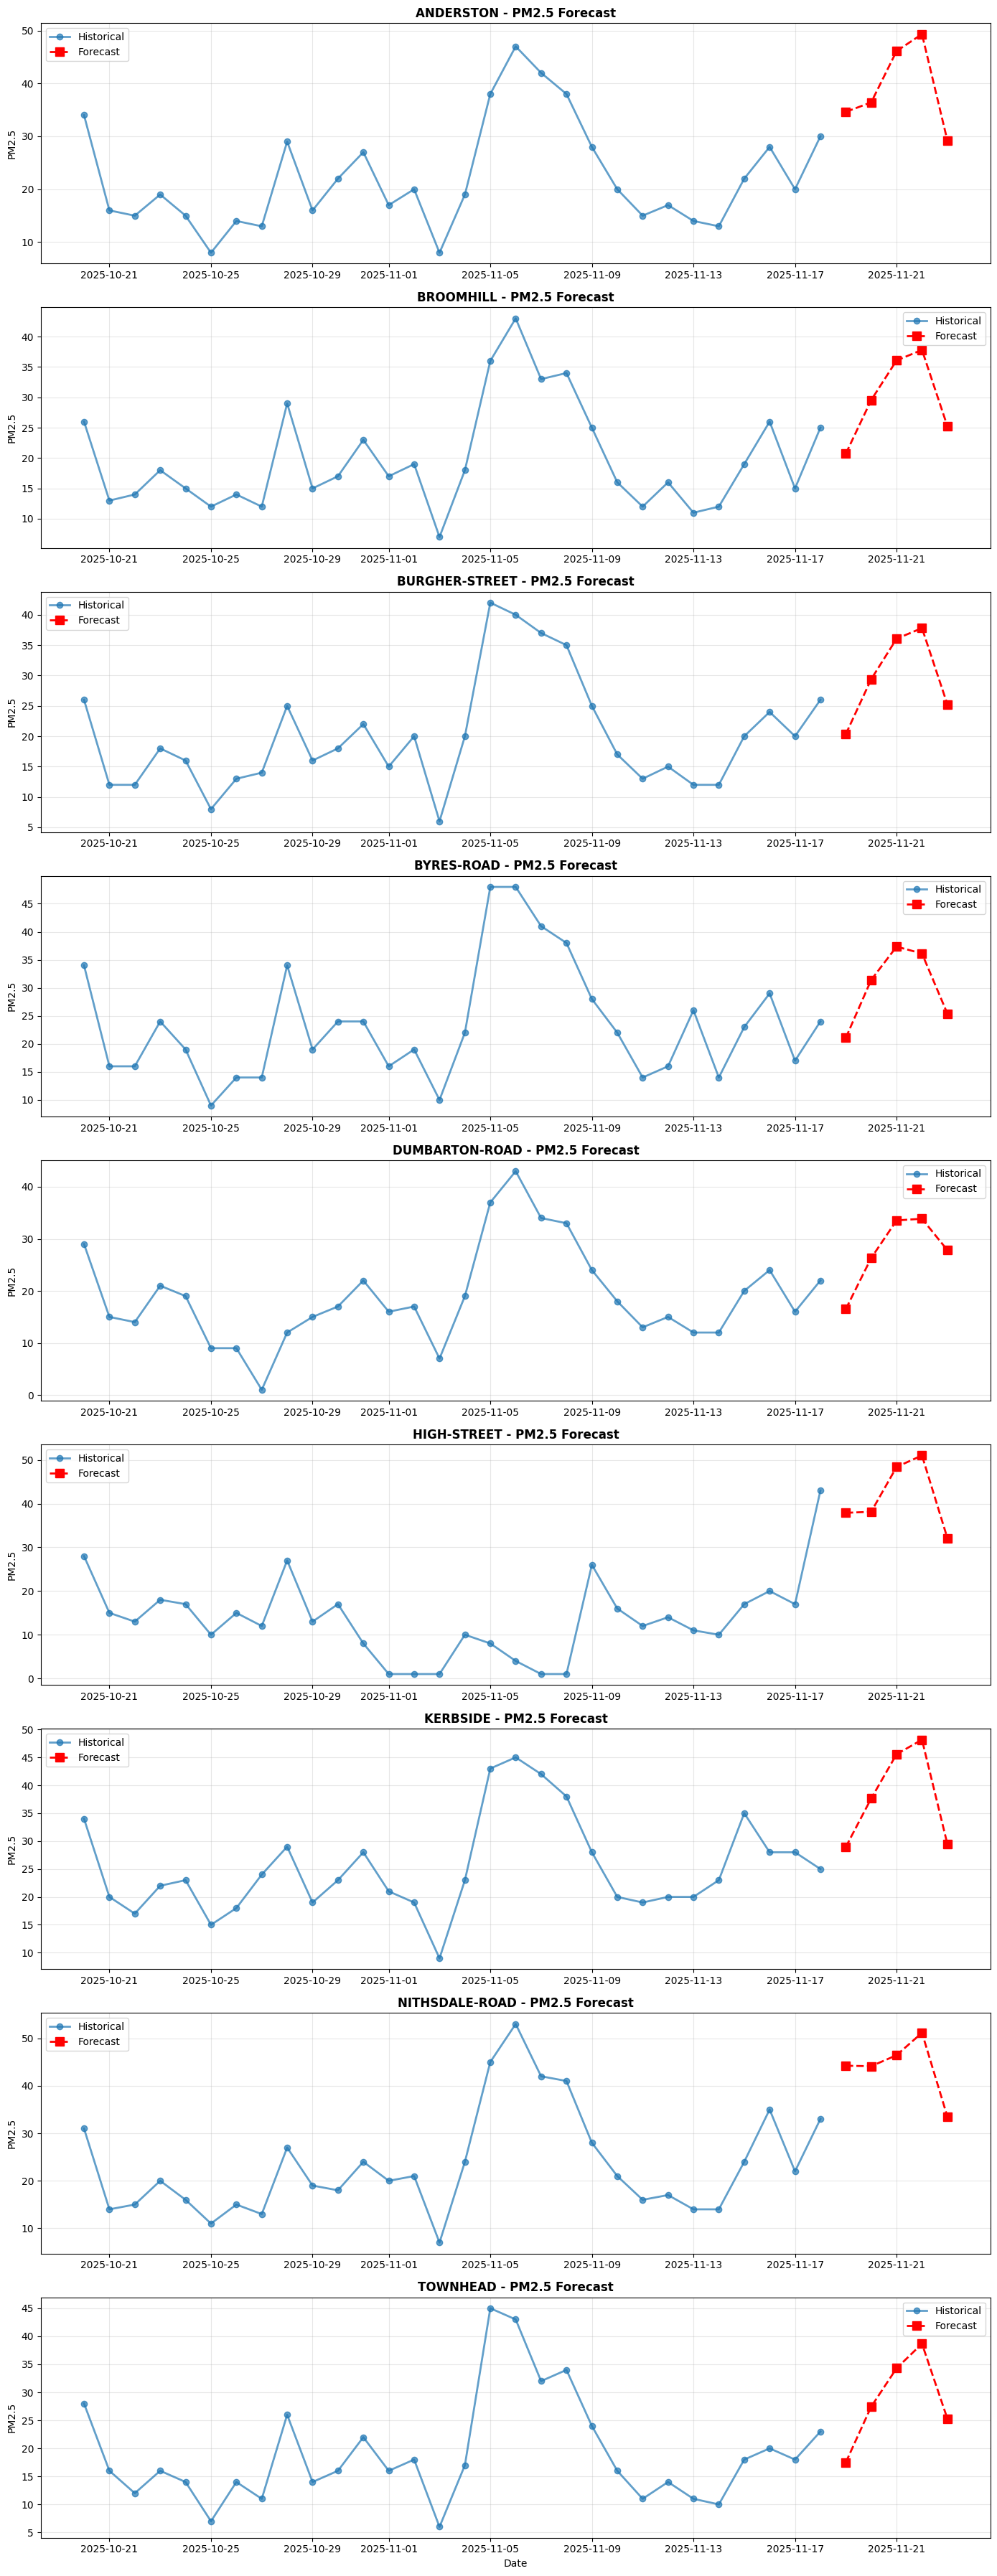

In [57]:
# 6. VISUALIZE PREDICTIONS
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(df_with_lags['street'].unique()), 1, 
                         figsize=(14, 4*len(df_with_lags['street'].unique())))

if len(df_with_lags['street'].unique()) == 1:
    axes = [axes]

for idx, street in enumerate(df_with_lags['street'].unique()):
    ax = axes[idx]
    
    # Historical data
    historical = df_with_lags[df_with_lags['street'] == street].tail(30)
    ax.plot(historical['date'], historical['pm25'], 
            marker='o', label='Historical', linewidth=2, alpha=0.7)
    
    # Predictions
    street_preds = predictions_df[predictions_df['street'] == street]
    ax.plot(street_preds['date'], street_preds['predicted_pm25'],
            marker='s', label='Forecast', linewidth=2, 
            linestyle='--', color='red', markersize=8)
    
    ax.set_title(f'{street.upper()} - PM2.5 Forecast', fontweight='bold')
    ax.set_ylabel('PM2.5')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('multi_sensor_forecast.png', dpi=150, bbox_inches='tight')
plt.show()